# Far-field emission from the Lieb lattice

(by Dmitry R. Gulevich, ITMO University, St. Petersburg, 197101, Russia)

## 1. Model

Here we calculate a far-field emission from the Lieb lattice as in our paper C. E. Whittaker et al., Phys. Rev. Lett. 120, 097401 (2018). 

Assumptions of the model: Linear regime. TE-TM splitting is neglected. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import exp2d # my module
import imp
#imp.reload(exp2d) # reload exp2d after update

In [5]:
### Physical parameters
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
Lconstant = 5.8 # lattice constant, micron
Rpillar = 1.5 # pillar radius, micron
UinmeV=0.-0.1*1j # meV
UoutmeV=10-0.5*1j # meV

In [6]:
### Numerical calculation parameters
M=20 # discretization, even number
Nbands=10 # number of bands to calculate
NBzones=4 # number of Brillouion zones to calculate

In [7]:
assert M%2==0
Mhalf=round(M/2)
hbar=1.05e-34 # reduced Planck constant, J s
E0=hbar*hbar/(2.*meff*Lconstant*Lconstant*1.e-12)/(1.6e-22) # characteristic energy, meV
dr=1./M
dr2=dr*dr

In [8]:
### Define potential in one unit cell
U = exp2d.U_Lieb(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)

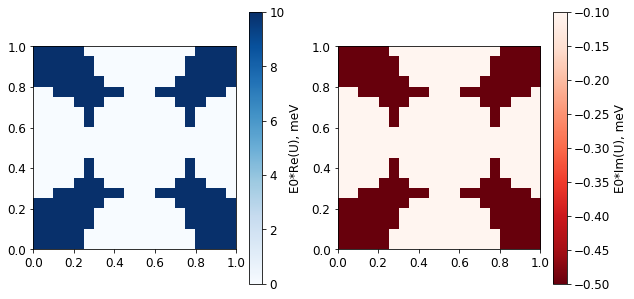

In [9]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*U.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*U.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

## Bloch states and band structure 

$$
-\Delta \psi_{n,\mathbf{k}}(\mathbf{r}) + \Re[U(x,y)] \,\psi_{n,\mathbf{k}}(\mathbf{r}) = E_n \psi_{n,\mathbf{k}}(\mathbf{r}),
$$

In [10]:
### Calculate band structure at ky=0.
kxrange = np.linspace(-np.pi,np.pi,30)
kyrange=np.array([0.])
%time evalsarr,evecsarr = exp2d.eigsystem(M, U, kxrange, kyrange, Nbands)

CPU times: user 634 ms, sys: 336 µs, total: 634 ms
Wall time: 320 ms


Text(0,0.5,'$E, \\rm meV$')

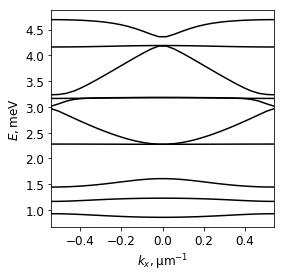

In [11]:
### Display the band structure
plt.rc('font', size=12)
fig,ax = plt.subplots(figsize=(4,4))
for i in range(Nbands):
    ax.plot(kxrange/Lconstant,E0*evalsarr[0][:,i],'k')  
ax.set_xlim([kxrange[0]/Lconstant,kxrange[-1]/Lconstant])
ax.set_xlabel(r"$k_x, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")

In [12]:
### Calculate Bloch states at (kx,ky)=(0,0)
kxrange=np.array([0.])
kyrange=np.array([0.])
%time evalsarr,evecsarr = exp2d.eigsystem(M, U, kxrange, kyrange, Nbands)

CPU times: user 39.2 ms, sys: 108 µs, total: 39.3 ms
Wall time: 22.2 ms


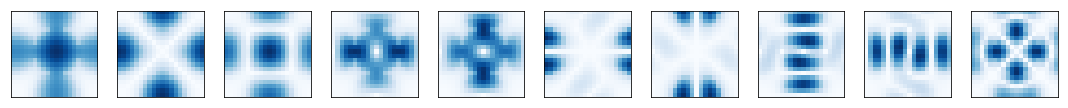

In [13]:
### Display Bloch states' probability density
fig, ax = plt.subplots(1,Nbands,figsize=(15,2))
for nv in range(Nbands):
    data=np.abs(evecsarr[0,0][nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = plt.cm.Blues, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])
plt.tight_layout()
plt.show()

## Time evolution from a random initial state

$$
i\frac{\partial\psi}{\partial t} = -\Delta \psi + \Re[U(x,y)]\,\psi + i\Im[U(x,y)]\,\psi, \quad \psi(\mathbf{r},0)=\psi_0(\mathbf{r})
$$

In [14]:
Ncells=8 # 12, integer number for symmetric display
Nframes=80 # 200
Nsamples=5 # 40
Emin=0.5
Emax=5.2
dt=0.002 # timestep
kylist = np.array([0., np.pi/2., np.pi, 3.*np.pi/2.]);
Length=1.0*Ncells # length of the domain

In [15]:
# Define potential in a supercell of Ncells x Ncells cells
Mglobal=Ncells*M
Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])

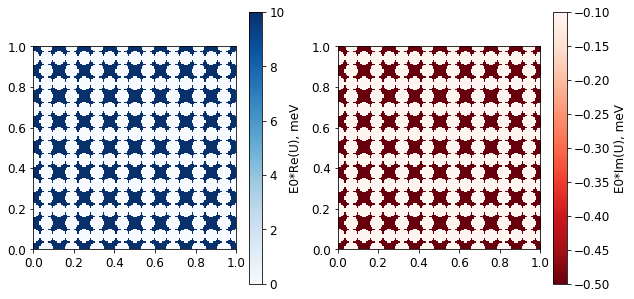

In [16]:
### Display potential
plt.rc('font', size=12)
fig,ax=plt.subplots(1,2,figsize=(10,5))
img0=ax[0].imshow(E0*Uglobal.real.T,cmap = plt.cm.Blues, extent=[0,1,0,1], origin='lower')
img1=ax[1].imshow(E0*Uglobal.imag.T,cmap = plt.cm.Reds_r, extent=[0,1,0,1], origin='lower')
plt.colorbar(img0,ax=ax[0],label='E0*Re(U), meV')
plt.colorbar(img1,ax=ax[1],label='E0*Im(U), meV')
plt.show()

In [17]:
dkx=2.*np.pi/Ncells
kmax=NBzones*np.pi
dtout = np.pi*E0/Emax # from the Nyquist frequency at Emax
countout=int(dtout/dt)
dE=2.*np.pi*E0/(Nframes*countout*dt)
krange = -np.pi + dkx*np.arange(Ncells) # over the BZ  

In [18]:
%time evalsarr,evecsarr = exp2d.eigsystem(M, U, krange, krange, Nbands)

CPU times: user 1.42 s, sys: 11.9 ms, total: 1.43 s
Wall time: 720 ms


In [19]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.evolve.restype = None
libcd.evolve.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_double, c_int, c_double, c_int, c_int,
        ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),  c_int]

# set number of OpenMP threads
libcd.omp_set_num_threads(2)

FPsiarr=np.empty((Nframes,len(kylist),Mglobal),dtype=np.complex128)

probsum=np.zeros((len(kylist),round(Emax/dE)-round(Emin/dE),
                  1+int(Mglobal*0.5+kmax/dkx)-int(Mglobal*0.5-kmax/dkx)), dtype=np.float64)

for sample in range(Nsamples):

    Psi=np.zeros((Mglobal,Mglobal),dtype=np.complex128)

    # Loop over BZ
    for n in range(Ncells):
        ky=-np.pi+n*dkx
        for m in range(Ncells):
            kx=-np.pi+m*dkx
            for nv in range(Nbands):

                psi=np.copy(evecsarr[n,m,nv].reshape(M,M))

                randphase = np.exp(1j*2.*np.pi*np.random.random_sample())
                for i in range(Ncells):
                    for j in range(Ncells):
                        Psi[i*M:(i+1)*M,j*M:(j+1)*M] += randphase*psi[:,:]*np.exp(1j*(kx*i+ky*j))

    libcd.evolve(Psi,FPsiarr,Length,M*Ncells,dt,Nframes,countout,Uglobal,kylist,kylist.size)
    
    for Pky in range(len(kylist)):
        fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[:,Pky,:],axis=0),axes=1)
        data=(fftarr*np.conjugate(fftarr)).real
        data1=data[::-1]
        data2=data1[round(Emin/dE):round(Emax/dE),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]
        probsum[Pky,:,:] += data2
        
    print("# Sample %d: done" % sample)     

# Sample 0: done
# Sample 1: done
# Sample 2: done
# Sample 3: done
# Sample 4: done


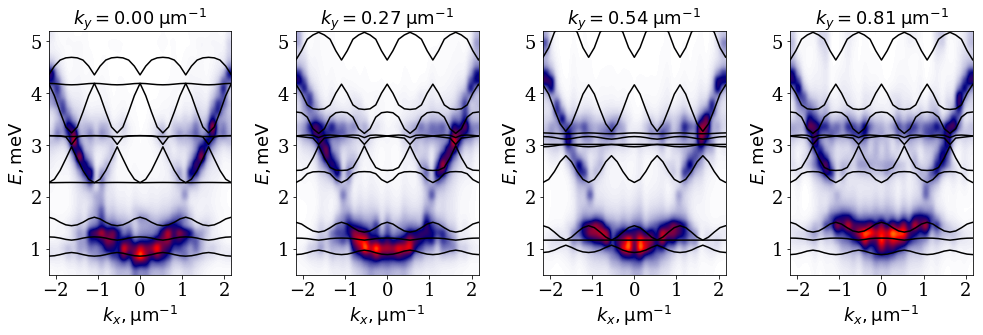

In [20]:
plt.rc('font', family='serif')
plt.rc('font', size='18')
fig, ax = plt.subplots(1, len(kylist), figsize=(14,5))

### Display the expected far field intensity
for Pky in range(len(kylist)):
    i=Pky
    img=ax[i].imshow(probsum[Pky],aspect='auto', interpolation='gaussian', 
                     extent=[-kmax/Lconstant,kmax/Lconstant,Emin,Emax], cmap = exp2d.mycmap, origin='lower')
    ax[i].set_xlabel(r'$k_x,\;\mu m^{-1}$')
    ax[i].set_xticks([-2,-1,0,1,2])
    ax[i].set_title(r'$k_y=%.2f\rm\; \mu m^{-1}$'%(kylist[Pky]/Lconstant), fontsize=18)
    #plt.colorbar(img,ax=ax[i])
ax[0].set_ylabel(r'$E,\;\rm meV$')

### Overlay the band structure
kxrange = np.concatenate(([2.*np.pi*n + krange for n in np.arange(-int(NBzones/2),1+int(NBzones/2))]))
for Pky in range(len(kylist)):
    nax=Pky
    ky = kylist[Pky] # normalized
    kyind = int(round((np.pi+kylist[Pky])/dkx))%Ncells
    evlist=evalsarr[kyind]
    for i in range(Nbands):
        evrange = np.concatenate(([evlist[:,i] for n in np.arange(-int(NBzones/2),1+int(NBzones/2))]))
        ax[nax].plot(kxrange/Lconstant,E0*evrange,'k')  
    ax[nax].set_xlim([-kmax/Lconstant,kmax/Lconstant])
    ax[nax].set_ylim([Emin,Emax])
    ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
    ax[nax].set_ylabel(r"$E, \rm meV$")

plt.tight_layout()
plt.show()